# ノンパラメトリック手法による生存時間データの記述法

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

%matplotlib inline

In [15]:
WHAS_SURVIVAL_DATASET_PATH = 'dataset/whas100.dat'
COLUMNS = ['登録日(観察開始日)', '追跡日(観察終了日)', '入院期間', '追跡日数(観察日数)', '生存状態', '登録時年齢', '性別', 'BMI']

whas_df = pd.read_csv(
        WHAS_SURVIVAL_DATASET_PATH,
        sep='\s+',
        header=None,
        index_col=0, 
        names=COLUMNS
    )
whas_df.head()

,登録日(観察開始日),追跡日(観察終了日),入院期間,追跡日数(観察日数),生存状態,登録時年齢,性別,BMI
1,03/13/1995,03/19/1995,4,6,1,65,0,31.38134
2,01/14/1995,01/23/1996,5,374,1,88,1,22.65790
3,02/17/1995,10/04/2001,5,2421,1,77,0,27.87892
4,04/07/1995,07/14/1995,9,98,1,81,1,21.47878
5,02/09/1995,05/29/1998,4,1205,1,78,0,30.70601


上のデータセットは、急性心筋梗塞にともなう入院後の生存時間データである。このデータを用いて、急性心筋梗塞にともなう入院からの生存時間に対して、性別、年齢、入院時のBMIが与える影響を調べる。

(array([ 10.,   6.,   3.,   2.,   4.,   0.,   0.,   2.,   1.,   4.,   1.,
          2.,   1.,   1.,   3.,   1.,   1.,   2.,   2.,   1.,   1.,   0.,
          1.,   0.,   2.]),
 array([    6.  ,   114.16,   222.32,   330.48,   438.64,   546.8 ,
          654.96,   763.12,   871.28,   979.44,  1087.6 ,  1195.76,
         1303.92,  1412.08,  1520.24,  1628.4 ,  1736.56,  1844.72,
         1952.88,  2061.04,  2169.2 ,  2277.36,  2385.52,  2493.68,
         2601.84,  2710.  ]),
 <a list of 25 Patch objects>)

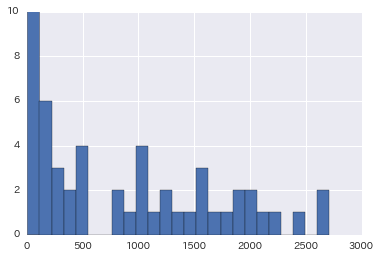

In [40]:
# plt.hist(y['Survival_in_days'], bins=100)
plt.hist(whas_df[whas_df['生存状態'] == 1]['追跡日数(観察日数)'].values, bins=25)

In [6]:
# print(y[y['Status'] == False].shape[0])
# print(y[y['Status'] == True].shape[0])

9
128


In [42]:
from sksurv.datasets import load_veterans_lung_cancer

x, y = load_veterans_lung_cancer()
x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,'squamous',60.0,7.0,'no','standard'
1,64.0,'squamous',70.0,5.0,'yes','standard'
2,38.0,'squamous',60.0,3.0,'no','standard'
3,63.0,'squamous',60.0,9.0,'yes','standard'
4,65.0,'squamous',70.0,11.0,'yes','standard'


 - `Age_in_years`: 年齢
 - `Celltype`: 細胞の種類; `[squamous(扁平上皮), small cell, adeno(腺癌), large]`
 - `Karnofsky_score`: カルノフスキースコア(がん患者の日常活動を遂行する能力を計るための標準的な値.0~100)
 - `Months_from_Diagnosis`: 診断からの経過月数
 - `Prior_therapy`: 前に治療したかいなか; `[yes, no]`
 - `Treatment`: 肺癌治療のタイプ; `[standard, test drug]`

In [43]:
y

array([( True,   72.), ( True,  411.), ( True,  228.), ( True,  126.),
       ( True,  118.), ( True,   10.), ( True,   82.), ( True,  110.),
       ( True,  314.), (False,  100.), ( True,   42.), ( True,    8.),
       ( True,  144.), (False,   25.), ( True,   11.), ( True,   30.),
       ( True,  384.), ( True,    4.), ( True,   54.), ( True,   13.),
       (False,  123.), (False,   97.), ( True,  153.), ( True,   59.),
       ( True,  117.), ( True,   16.), ( True,  151.), ( True,   22.),
       ( True,   56.), ( True,   21.), ( True,   18.), ( True,  139.),
       ( True,   20.), ( True,   31.), ( True,   52.), ( True,  287.),
       ( True,   18.), ( True,   51.), ( True,  122.), ( True,   27.),
       ( True,   54.), ( True,    7.), ( True,   63.), ( True,  392.),
       ( True,   10.), ( True,    8.), ( True,   92.), ( True,   35.),
       ( True,  117.), ( True,  132.), ( True,   12.), ( True,  162.),
       ( True,    3.), ( True,   95.), ( True,  177.), ( True,  162.),
      

観測期間中に死亡した場合は`Status`が`True`になり、`False`の場合は右側打切りである。

---
## 生存関数の推定


In [33]:
whas_df['生存状態'].replace({1: True, 0: False}, inplace=True)

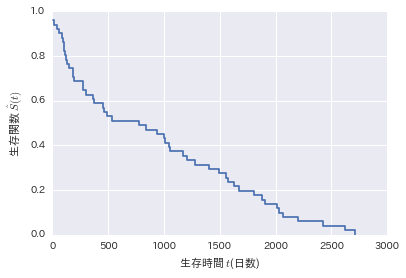

In [45]:
from sksurv.nonparametric import kaplan_meier_estimator

only_dead = whas_df['生存状態'] == True

survival_bools = whas_df[only_dead]['生存状態'].values
survival_times = whas_df[only_dead]['追跡日数(観察日数)'].values

time, survival_prob = kaplan_meier_estimator(survival_bools, survival_times)

plt.step(time, survival_prob, where="post")
plt.ylim(0, 1)
plt.ylabel("生存関数 $\hat{S}(t)$")
plt.xlabel("生存時間 $t$(日数)")

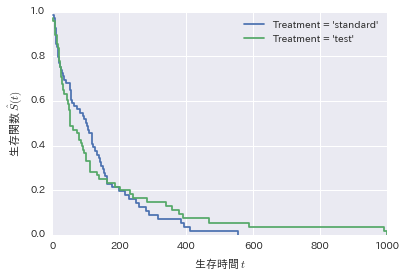

In [46]:
for treatment_type in x.Treatment.unique():
    target_indexs = x[x.Treatment == treatment_type].index
    time, survival_prob = kaplan_meier_estimator(
        y[target_indexs]['Status'], 
        y[target_indexs]['Survival_in_days']
    )
    plt.step(time, survival_prob, where="post", label='Treatment = {0}'.format(treatment_type))

plt.ylim(0, 1)
plt.ylabel("生存関数 $\hat{S}(t)$")
plt.xlabel("生存時間 $t$")
plt.legend()
plt.show()